In [1]:
from floorplan import Box, Net, FloorPlan

import cvxpy as cp
from cvxpy import Variable, Constant, Minimize, Problem
import placedb
import pylab
import math

import joblib

from sklearn.manifold import SpectralEmbedding

import scipy.io as io
import scipy.sparse.csgraph as csgraph

import jax
from jax import jit, vmap, random, grad
# from jax.experimental import optimizers
from jax.example_libraries import optimizers
from jax import numpy as jnp

from functools import partial
import itertools

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import collections as mc

import datetime
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
from ucsdpcb import PcbDB

trying to import ucsdpcb._PcbDB


In [3]:
!ls PCBBenchmarks/

bm9  test


In [4]:
numCores = joblib.cpu_count()

bm = 9 # which benchmark to load
design = "bm{}".format(bm)
# pcb_path = "PCBBenchmarks/bm{}/bm{}.routed.kicad_pcb".format(bm,bm)
# pcb_path = "/home/yuw/Desktop/Github/PCBPlacer/PCBPlacer/PCBBenchmarks/test.kicad_pcb"
pcb_path = "PCBBenchmarks/bm9/bm9.routed_modified.kicad_pcb"
# pcb_path = "_PCBBenchmarks/bm9/bm9.routed.kicad_pcb"
db = PcbDB.kicadPcbDataBase(pcb_path)

Build Kicad Pcb database...


(17.7934 10.847 2)


In [5]:
compw = []
comph = []
compx = []
compy = []
movable = []
initrot = []
initm = []
mirror = []
netss = []
offsets = []
size = []

maxx = 0
maxy = 0
minx = 99999999
miny = 99999999

constraint_threshold = 0 # distance between pairs of components to determine relative position constraints

In [6]:
db.getInstancesCount()

8

In [7]:
inst = db.getInstance(7)
compid = inst.getComponentId()
print(db.getCompBBoxW(compid))
print(db.getCompBBoxH(compid))
inst.getX()
print(inst.getAngle())
inst.isLocked()

10.2
3.7
90.0


True

In [8]:
sumarea = 0
# gather rotation and coordinates of components
for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()

    # print instance name
    print("inst name: {}".format(inst.getName()))

    angle = int(inst.getAngle())
    if inst.isLocked():
        movable.append(False)
    else:
        movable.append(True)
    if (angle == 0):
        initrot.append(False)
        initm.append(False)
    elif (angle == 90):
        initrot.append(True)
        initm.append(False)
    elif (angle == 180):
        initrot.append(False)
        initm.append(True)
    elif (angle == 270):
        initrot.append(True)
        initm.append(True)
    print(str(compid) + " => getCompBBoxW " + str(db.getCompBBoxW(compid)))
    print("     getCompBBoxH " + str(db.getCompBBoxH(compid)))
    print("     getCompBBoxX " + str(inst.getX()))
    print("     getCompBBoxY " + str(inst.getY()))

    compx.append(inst.getX() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxW(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxH(compid)))
    compy.append(inst.getY() - 0.5 * ((1-int(initrot[-1]))*db.getCompBBoxH(compid) + 
                                      (int(initrot[-1]))*db.getCompBBoxW(compid)))
    compw.append(db.getCompBBoxW(compid))
    comph.append(db.getCompBBoxH(compid))
    
    if compx[-1] < minx:
        minx = compx[-1]
    if compy[-1] < miny:
        miny = compy[-1]
        
    if True:
        if compx[-1] + comph[-1] > maxx:
            maxx = compx[-1] + comph[-1]
        if compy[-1] + compw[-1] > maxy:
            maxy = compy[-1] + compw[-1]
    else:
        if compx[-1] + compw[-1] > maxx:
            maxx = compx[-1] + compw[-1]
        if compy[-1] + comph[-1] > maxy:
            maxy = compy[-1] + comph[-1]
    
    print("     index: {} x: {} y: {} w: {} h: {}".format(i, compx[-1], compy[-1], compw[-1], comph[-1]))
    print("     angle: {} init_Rotation: {} init_Mirror: {}".format(angle, initrot[-1], initm[-1]))
    print("")
    # print(dir(inst))
    # print("     getPadCount: {}".format(inst.getPadCount()))
    sumarea += db.getCompBBoxW(compid)* db.getCompBBoxH(compid)
print("util: {}".format(sumarea/((maxx-minx)*(maxy-miny))))
print('num nodes: {} ({} movable)'.format(len(compx), len([m for m in movable if m]))) 

print("[INFO] maxx: {} maxy: {}".format(maxx, maxy))
print("[INFO] minx: {} miny: {}".format(minx, miny))

inst name: "U1"
0 => getCompBBoxW 4.04
     getCompBBoxH 2.06
     getCompBBoxX 149.606
     getCompBBoxY 100.8634
     index: 0 x: 148.576 y: 98.8434 w: 4.04 h: 2.06
     angle: 270 init_Rotation: True init_Mirror: True

inst name: "U2"
0 => getCompBBoxW 4.04
     getCompBBoxH 2.06
     getCompBBoxX 151.8666
     getCompBBoxY 100.8634
     index: 1 x: 150.8366 y: 98.8434 w: 4.04 h: 2.06
     angle: 270 init_Rotation: True init_Mirror: True

inst name: "U3"
0 => getCompBBoxW 4.04
     getCompBBoxH 2.06
     getCompBBoxX 140.5636
     getCompBBoxY 105.2322
     index: 2 x: 139.5336 y: 103.21220000000001 w: 4.04 h: 2.06
     angle: 90 init_Rotation: True init_Mirror: False

inst name: "U4"
0 => getCompBBoxW 4.04
     getCompBBoxH 2.06
     getCompBBoxX 142.7988
     getCompBBoxY 100.6856
     index: 3 x: 140.7788 y: 99.65559999999999 w: 4.04 h: 2.06
     angle: 180 init_Rotation: False init_Mirror: True

inst name: "U5"
1 => getCompBBoxW 6.2
     getCompBBoxH 6.2
     getCompBBoxX 145.05

In [9]:
netss = []
offsets = []
"""Gather pin offset information """
for i in range(db.getNumNets()):
    net = db.getNet(i)
    netname = net.getName()
    # convert SwigPyObject to string
    # print(dir(netname))
    netname = str(netname.__str__())
    print("[INFO] netname: {}".format(netname))
    pins = net.getPins()
    netss.append([])
    offsets.append([])
    for p in pins:
        instid = p.getInstId()
        netss[-1].append(instid)
        px = db.getPinPositionX(p)
        py = db.getPinPositionY(p)
        inst = db.getInstance(instid)
        ix = inst.getX() 
        iy = inst.getY()
        # why???
        w = comph[instid]
        h = compw[instid]
        # w = compw[instid]
        # h = comph[instid]

        print("[INFO] instID {} pad_x {} pad_y {} inst_x {} inst_y {} w {} h {} angle {} init_Rotation {}".format(instid, px, py, ix, iy, w, h, angle, initrot[instid]))

        angle = int(inst.getAngle())
        # print(angle)
        # print(initrot[instid])

        xoff = (1-int(initrot[instid]))*(px-ix)/h + (int(initrot[instid]))*(px-ix)/w
        yoff = (1-int(initrot[instid]))*(py-iy)/w + (int(initrot[instid]))*(py-iy)/h
        print("x_offset: {} y_offset: {}".format(xoff, yoff))
        print("")
        assert np.abs(xoff) < 1.0
        assert np.abs(yoff) < 1.0
        if True:
            t = xoff
            xoff = yoff
            yoff = t

        if (angle == 0):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 90):##
            offsets[-1].append((yoff,xoff))
        elif (angle == 180):##
            offsets[-1].append((xoff,yoff))
        elif (angle == 270):##
            offsets[-1].append((yoff,xoff))
        else:
            assert False
            
offsets = [o for o, n in zip(offsets, netss) if len(n)>=2]        
netss = [n for n in netss if len(n)>= 2]
netlens = [len(n) for n in netss]
print(netlens)
maxlenidx = np.array(netlens).argsort()[-2:]
print(maxlenidx)  

print(len(offsets))
offsets = [o for i,o in enumerate(offsets) if i not in maxlenidx]
netss = [n for i,n in enumerate(netss) if i not in maxlenidx]

print(len(offsets))

[INFO] netname: <Swig Object of type 'std::string *' at 0x7fa83d7c3c00>
[INFO] netname: <Swig Object of type 'std::string *' at 0x7fa83d7c36c0>
[INFO] instID 0 pad_x 149.60600001132863 pad_y 101.8134 inst_x 149.606 inst_y 100.8634 w 2.06 h 4.04 angle 90 init_Rotation True
x_offset: 5.499338632802992e-09 y_offset: 0.23514851485148586

[INFO] instID 1 pad_x 151.86660001132864 pad_y 101.8134 inst_x 151.8666 inst_y 100.8634 w 2.06 h 4.04 angle 270 init_Rotation True
x_offset: 5.499338632802992e-09 y_offset: 0.23514851485148586

[INFO] instID 3 pad_x 143.7488 pad_y 100.68559991694836 inst_x 142.7988 inst_y 100.6856 w 2.06 h 4.04 angle 270 init_Rotation False
x_offset: 0.23514851485148233 y_offset: -4.031632589801817e-08

[INFO] instID 4 pad_x 147.18839999105634 pad_y 104.45679997461193 inst_x 145.0594 inst_y 105.2068 w 6.2 h 6.2 angle 180 init_Rotation True
x_offset: 0.3433870953316665 y_offset: -0.12096774603033478

[INFO] instID 4 pad_x 147.1883999970188 pad_y 104.95679997461193 inst_x 14

In [10]:
"""Instantiate MILP variables """
nets = []
for i, net in enumerate(netss):
    nodes = net
    pin_offsets = offsets[i]
    
    # ignore 1-pin nets
    if len(nodes) <=1: continue
    print(nodes)
    nets.append(Net(nodes, pin_offsets, i))
    
boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))

    placeable_area = (56,52)

num_nets = len(netss)
num_nodes = len(boxes)
adj=np.zeros((num_nodes,num_nodes))
print("num_nets: {} num_nodes: {}".format(num_nets, num_nodes))
for netid, net in enumerate(netss):
    for nodeid1 in net:
        for nodeid2 in net:
            adj[nodeid1,nodeid2] += 1
  
# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compx, compy)):
    for i2, x2 in enumerate(zip(compx, compy)):
        if i2 <= i1:
            continue
        # if distance greater than threshold
        if max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > constraint_threshold:
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]):
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2,i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2,i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]

print('num horizontal & vertical constraints:',len(horiz_order),len(vert_order))

[4, 7]
[4, 7]
[4, 6]
[4, 5]
[2, 4]
[2, 4]
[3, 4]
num_nets: 7 num_nodes: 8
num horizontal & vertical constraints: 20 8


8
Compiled constraints
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 20 04:19:37 PM: Your problem has 108 variables, 312 constraints, and 0 parameters.
(CVXPY) Jul 20 04:19:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 04:19:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 04:19:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 04:19:37 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 04:19:37 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr

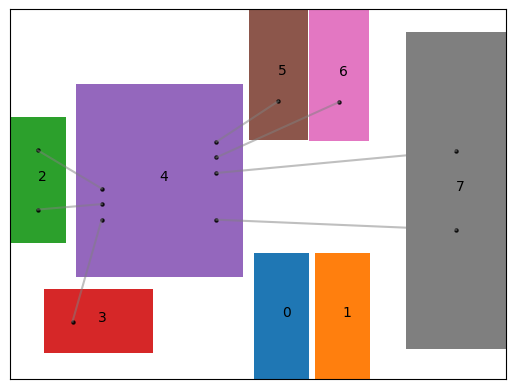

In [11]:
# First, just plot the manual layout (set all components to not be movable / rotateable / no constraints)
boxes = []
horiz_order = []
vert_order = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=False, pl=False, m=False))
print(len(boxes))
    
fp = FloorPlan(boxes, nets,adj,obj=False,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)
p, c = fp.layout()
print(fp.h.value)
fp.show()

num horizontal & vertical constraints: 7 0
Compiled constraints
                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 20 04:19:37 PM: Your problem has 261 variables, 655 constraints, and 0 parameters.
(CVXPY) Jul 20 04:19:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 20 04:19:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 20 04:19:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 20 04:19:37 PM: Compiling problem (target solver=CBC).
(CVXPY) Jul 20 04:19:37 PM: Re

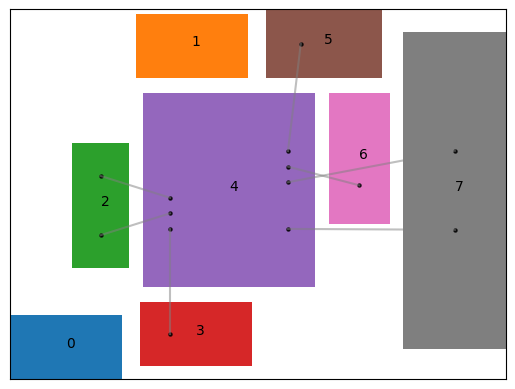

In [12]:
# Now, try making the movable components movable,
# and impose constraints on just the fixed nodes:

# order constraints
vo = []
ho = []

norelpairs = []

for i1, x1 in enumerate(zip(compx, compy)):
    for i2, x2 in enumerate(zip(compx, compy)):
        if i2 <= i1:
            continue
        # one of the two is a fixed node
        if ((not movable[i1]) or (not movable[i2])):
            # check horizontal and vertical direction and max difference
            if abs(x1[0] - x2[0]) < abs(x1[1] - x2[1]) and \
            max(abs(x1[0] - x2[0]), abs(x1[1] - x2[1])) > 10:
                if x1[1] < x2[1]:
                    vo.append([i1, i2])
                else:
                    vo.append([i2, i1])
            else:
                if x1[0] < x2[0]:
                    ho.append([i1, i2])
                else:
                    ho.append([i2, i1]) 
        else:
            norelpairs.append([i1,i2])

horiz_order = [[boxes[i] for i in h] for h in ho]
vert_order = [[boxes[i] for i in v] for v in vo]
print('num horizontal & vertical constraints:',len(horiz_order),len(vert_order))

boxes = []
for i in range(len(compw)):
    boxes.append(Box(compw[i], comph[i], compx[i], compy[i], 
                     initialr =[not r for r in initrot][i], initialmx=0, initialmy=0, idx=i, 
                     r=movable[i], pl=movable[i], m=False))
    
fp = FloorPlan(boxes, nets,adj,obj=True,norelpairs=None, ox=minx,oy=miny,boundary_W=maxx-minx, boundary_H=maxy-miny, 
               margin=0.5,horizontal_orderings=horiz_order, vertical_orderings=vert_order, 
               max_seconds=3800, num_cores=numCores-1, name=design)
p, c = fp.layout()
print(fp.h.value)
fp.show()

In [13]:
"""write back to db """
for i in range(db.getInstancesCount()):
    inst = db.getInstance(i)
    compid = inst.getComponentId()
    
    box = fp.boxes[i]
    
    xpos = box.x.value.item() + 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].w.value + 
                                          (fp.boxes[i].r.value)*fp.boxes[i].h.value)
    ypos = box.y.value.item()+ 0.5 * ((1-fp.boxes[i].r.value)*fp.boxes[i].h.value + 
                                         (fp.boxes[i].r.value)*fp.boxes[i].w.value)
    inst.setX(xpos)
    inst.setY(ypos)

    rotated = box.r.value
    mirroredX = box.mx.value.item()
    mirroredY = box.my.value.item()
    
    init_angle = inst.getAngle()
 
    print(i, xpos, ypos, box.w, box.h,init_angle, rotated)

    if (init_angle==0) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==0) and (rotated == 1.0):
        inst.setAngle(0)
    elif (init_angle==90) and (rotated == 0.0):
        inst.setAngle(90)
    elif (init_angle==90) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==180) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==180) and (rotated == 1.0):
        inst.setAngle(180)
    elif (init_angle==270) and (rotated == 0.0):
        inst.setAngle(270)
    elif (init_angle==270) and (rotated == 1.0):
        inst.setAngle(0)
    print(i, xpos, ypos, box.w, box.h,inst.getAngle(), rotated)    
    

0 142.0536 99.8734 2.06 4.04 270.0 1.0
0 142.0536 99.8734 2.06 4.04 0.0 1.0
1 146.5936 109.5404 2.06 4.04 270.0 1.0
1 146.5936 109.5404 2.06 4.04 0.0 1.0
2 143.30300000000003 104.41040006393268 2.06 4.04 90.0 0.0
2 143.30300000000003 104.41040006393268 2.06 4.04 90.0 0.0
3 146.75399998509397 100.28040000000001 2.06 4.04 180.0 1.0
3 146.75399998509397 100.28040000000001 2.06 4.04 180.0 1.0
4 147.933 104.9104 6.2 6.2 270.0 0.0
4 147.933 104.9104 6.2 6.2 270.0 0.0
5 151.37399998509395 109.61040000000001 2.2 4.2 270.0 1.0
5 151.37399998509395 109.61040000000001 2.2 4.2 0.0 1.0
6 152.63300000000004 105.91040000000001 2.2 4.2 270.0 0.0
6 152.63300000000004 105.91040000000001 2.2 4.2 270.0 0.0
7 156.083 104.902 3.7 10.2 90.0 0.0
7 156.083 104.902 3.7 10.2 90.0 0.0


In [14]:
"""print db to file """
db.printKiCad()

printKiCad() outputFileName: output.bm9.routed_modified.kicad_pcb
